## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [45]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import gc
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [89]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [90]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [91]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [92]:
df[df['converted'] == 1]['user_id'].nunique() / df.user_id.nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [93]:
df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')].shape[0] + df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')].shape[0]

3893

f. Do any of the rows have missing values?

In [94]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [95]:
remov = df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')].append(df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')])
df2 = df.append(remov).drop_duplicates(keep=False)
df2.shape

(290585, 5)

In [96]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [97]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [98]:
df2[df2.duplicated(['user_id'], keep='first')].index

Int64Index([2893], dtype='int64')

c. What is the row information for the repeat **user_id**? 

In [99]:
df2[df2.duplicated(['user_id'], keep='last')]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


In [100]:
df2.shape

(290585, 5)

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [101]:
df2.user_id.drop_duplicates(keep='first', inplace=False).shape

(290584,)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2[df2['converted'] == 1].shape[0] / df2['converted'].shape[0]

0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
prob_old = df2[df2['group'] == 'control']['converted'].mean()
prob_old

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
prob_new = df2[df2['group'] == 'treatment']['converted'].mean()
prob_new

0.11880724790277405

d. What is the probability that an individual received the new page?

In [18]:
df2[df2['landing_page'] == 'new_page'].shape[0] / df2.shape[0]

0.5000636646764286

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Your answer goes here.**

##### From the  observations, each group has almost equal proportion. The probability of conversion after seeing the old or new page is $\approx 12 \text{%}$. Hence; individuals who were presented with the old page are, equally likely to convert when compared with those with the new page. Therefore; there is no enough evidence to say "the new page leads to more conversions".

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

##### Null : conversion mean for treatment group - conversion mean for control group =< 0

##### alternative : conversion mean for treatment group - conversion mean for control group > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2[df2['converted'] == 1].shape[0] / df2['converted'].shape[0]
p_new

0.11959667567149027

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2[df2['converted'] == 1].shape[0] / df2['converted'].shape[0]
p_old

0.11959667567149027

c. What is $n_{new}$?

In [21]:
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]
n_new

145311

d. What is $n_{old}$?

In [22]:
n_old = df2[df2['landing_page'] == 'old_page'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = []

sim_new = np.random.choice([0,1], size = n_new, p=[1-p_new, p_new])
new_page_converted.append(sim_new)

new_page_converted = np.array(new_page_converted)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = []

sim_old = np.random.choice([0,1], size = n_old, p=[1-p_old, p_old])
old_page_converted.append(sim_old)

old_page_converted = np.array(old_page_converted)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

-0.00012693549962249084

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
p_diffs = []

for i in range(10000):
    new_conv = np.random.choice([0,1], size = n_new, p=[1-p_new, p_new])
    old_conv = np.random.choice([0,1], size = n_old, p=[1-p_old, p_old])
    p_diffs.append(new_conv.mean() - old_conv.mean())

In [27]:
obsv_diff = prob_new - prob_old
obsv_diff

-0.0015790565976871451

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

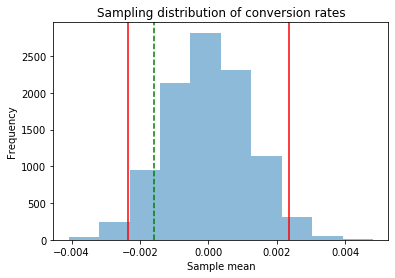

In [28]:
plt.hist(p_diffs, alpha=0.5)
plt.axvline(x=np.percentile(p_diffs, 2.5), color='red')
plt.axvline(x=np.percentile(p_diffs, 97.5), color='red')
plt.axvline(x=obsv_diff, color='green', linestyle = '--')
plt.title('Sampling distribution of conversion rates')
plt.ylabel('Frequency')
plt.xlabel('Sample mean');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
(np.array(p_diffs) > obsv_diff).mean()

0.9037

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here.**

##### The value computed above is, the probability of seeing the sample statistic if the null hypothesis is true. In scientific studies this value is called p-value. In our case; it means that the probability of getting the observed_diff is high if the null hypothesis is true. Hence; if the null hypothesis is true, conversions through the old page are equal or higher when compared with the new page. As a result; we can conclude that the old page is performing the same as the new webpage.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [37]:
import statsmodels.api as sm

convert_old = len(df2.query('landing_page == "old_page" & converted == 1'))
convert_new = len(df2.query('landing_page == "new_page" & converted == 1'))
#n_old previously computed 
#n_new previously computed 

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [39]:
stat, pval = sm.stats.proportions_ztest(count=[convert_old, convert_new], nobs=[n_old,n_new],
                                        value = 0, alternative='smaller')
print('z-statistic=',stat)
print('p-value=',pval)

z-statistic= 1.3116075339133115
p-value= 0.905173705140591


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**

##### With 0.05 type 1 error rate (0.95 confidence level), the null hypothesis gets rejected if Z-score of the sample statistic is less than -1.96 or greater than +1.96. However; Z-score is -1.31, which is out of the rejection region. Furthermore; the p-value is close to 1, which signifies we have to stay with the null hypothesis (the old page is performing in the same way as the new page). So, there is no statistically significant evidence to reject the null hypothesis, and this conclusion matches with the findings in question f. and g.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

##### Logistic regression, since this is a classification task

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [102]:
df2['ab_page'] = pd.get_dummies(df2['landing_page']).iloc[:,0]
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [67]:
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [68]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.6032
Date:               2020-07-03 08:29 BIC:              212801.7625
No. Observations:   290585           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290583           LLR p-value:      0.18965    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3116  0.1897  -0.0374   0.0074
==================================================================

"""

In [118]:
print('With all other elements held constant treatment users are', 1/np.exp(-0.0150), 'times less likely to convert than control users')

With all other elements held constant treatment users are 1.015113064615719 times less likely to convert than control users


e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Put your answer here.**

##### The p-value associated with the *ab_page* coeeficient in the regression model is different than the p-value obtained from the z-test. In the case of the resgression model it is the probability of type-1 errors for the null hypothesis which is the coefficient = 0

##### Null: Coefficient  = 0
##### Alternate hypothesis : Coefficient  != 0

##### and as shown the p value is at 0.189(almost 19%) which is way farther than out 0.05(5%) confidence threshold. Therefore, we will fail to reject the null and and conclude the coefficient iss *NOT* statistically significant to be considered in prediction of the conversion probability 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [77]:
country = pd.read_csv('countries.csv')
country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [78]:
country.shape

(290584, 2)

In [79]:
country.isnull().sum()

user_id    0
country    0
dtype: int64

In [107]:
country['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [110]:
df2 = df2.join(country.set_index('user_id'), on='user_id')
df2[['UK', 'CA']] = pd.get_dummies(df2['country'], drop_first=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,UK,CA
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,1


In [111]:
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page','UK', 'CA']])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [112]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.3782
Date:               2020-07-03 08:56 BIC:              212823.6968
No. Observations:   290585           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.17584    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2486  0.0000  -2.0822  -1.9778
ab_page       -0.0150    0.0114   -1.3076  0.1910  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
CA             0.0408    0.0269    1.5159  0.1296  -0.0119   0.0934
==================================================================

"""

In [116]:
print('With every other factor held constant, users from Uk are',np.exp(0.0506).round(2), 'times more likely to convert than users from the US')
print('With every other factor held constant, users from CA are',np.exp(0.0408).round(2), 'times more likely to convert than users from the US')

With every other factor held constant, users from Uk are 1.05 times more likely to convert than users from the US
With every other factor held constant, users from CA are 1.04 times more likely to convert than users from the US


**Does it appear that country had an impact on conversion?**

##### No, it appears not


**Explaination:**

##### The p-value associated with the coeefficiect of both Canada and UK are both past the 0.05(5%) threshold for a 95% confidence interval 

In [119]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0